<a href="https://colab.research.google.com/github/neuralsrg/SequenceModels/blob/main/music_gen_pretty_midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music generation with pretty_midi & pyfluidsynth

pretty_midi [tutorial](https://github.com/craffel/pretty-midi/blob/main/Tutorial.ipynb)

In [ ]:
# install libs

#! sudo apt install -y fluidsynth
! sudo apt-get install -qq -y -o=Dpkg::Use-Pty=0 fluidsynth

! pip install -q --upgrade pyfluidsynth
! pip install -q --upgrade pretty_midi

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import fluidsynth
import pretty_midi
from librosa.display import specshow

import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob
import os 
from IPython import display
from tqdm import tqdm, trange
import collections

from typing import Optional, Sequence, Dict, List, Any

## MusicHandler class contains methods for working with .midi files

In [31]:
class MusicHandler():


  def __init__(self):

    self.data_dir : pathlib.Path = None # data directory
    self.filenames : List[str] = [] # list of paths to .midi files
    self.pm : List[pretty_midi.PrettyMIDI] = [] # list of pretty_midi objects


  def download_data(self, origin_url : str) -> None:
    ''' Downloads data given origin URL '''

    self.data_dir = pathlib.Path('data/maestro-v2.0.0')
    if not self.data_dir.exists():
      tf.keras.utils.get_file(
          'maestro-v2.0.0-midi.zip',
          origin=origin_url,
          extract=True,
          cache_dir='.', cache_subdir='data',
      )
    self.filenames = glob.glob(os.path.join(self.data_dir, '**/*.mid*'))
    print('Number of files:', len(self.filenames))


  def gen_pretty_midi(self, file_inds : Sequence[int]) -> None:
    ''' Converts file paths to pretty_midi objects '''
    
    print('Creating PrettyMIDI objects...')
    self.pm = [pretty_midi.PrettyMIDI(self.filenames[ind]) for ind in tqdm(file_inds)]

  
  def plot_piano_roll(self, pm_index : int, start_pitch : int,
                      end_pitch : int, fs : Optional[int] = 100) -> None:
    ''' Plots piano roll of [pm_index]-th[start_pitch:end_pitch] pretty_midi object '''

    specshow(self.pm[pm_index].get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))


  @classmethod
  def play_audio(self, pm : pretty_midi.PrettyMIDI, duration : int,
                 synt_frequency : Optional[int] = 16000) -> display.Audio:
    ''' Returns display.Audio for pretty_midi object '''

    wave = pm.fluidsynth(fs=synt_frequency)[:duration * synt_frequency]
    return display.Audio(wave, rate=synt_frequency)


  def print_instrument_info(self, pm_index : Sequence[int]) -> None:
    ''' Prints info for [pm_index]-th pretty_midi object '''

    for index in pm_index:
      instruments = self.pm[index].instruments
      print(f'Total number of instruments in {index}-th midi file: {len(instruments)}\n')
      for instrument in instruments:
        print(pretty_midi.program_to_instrument_name(instrument.program))
        print(f'\t{len(instrument.notes)} notes')
        print(f'\t{len(instrument.pitch_bends)} pitch bends')
        print(f'\t{len(instrument.control_changes)} control changes \n')

  
  def count_notes(self, pm_index : Sequence[int]) -> int:
    ''' Counts total number of notes in self.pm '''

    n_notes = 0
    for index in pm_index:
      instruments = self.pm[index].instruments
      for instrument in instruments:
        n_notes += len(instrument.notes)

    return n_notes

  
  def midi_to_notes(self, pm_index : int, instrument_index : int) -> pd.DataFrame:
    ''' Creates pd.DataFrame containing data from [pm_index]-th
    pretty_midi object for [instrument_index]-th instrument for sequence model training '''

    instrument = self.pm[pm_index].instruments[instrument_index]
    extracted_notes : Dict[str, List[Any]] = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      pitch = note.pitch
      extracted_notes['pitch'].append(pitch)
      extracted_notes['note'].append(pretty_midi.note_number_to_name(pitch))
      extracted_notes['start'].append(start)
      extracted_notes['end'].append(end)
      extracted_notes['step'].append(start - prev_start)
      extracted_notes['duration'].append(end - start)
      prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value \
                                    in extracted_notes.items()})
    

  @classmethod
  def plot_distributions(self, notes : pd.DataFrame,
                         drop_percentile : Optional[int] = 2.5) -> None:
    ''' Plots distributions of training data '''

    try:
      fig = plt.figure(figsize=(15, 5))

      ax = fig.add_subplot(131)
      sns.histplot(notes['pitch'], bins=20)

      ax = fig.add_subplot(132)
      max_step = np.percentile(notes['step'], 100 - drop_percentile)
      sns.histplot(notes['step'], bins=np.linspace(0, max_step, 21))

      ax = fig.add_subplot(133)
      max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
      sns.histplot(notes['duration'], bins=np.linspace(0, max_duration, 21))

    except TypeError:
      print('Nothing to plot. (Consider creating training data with midi_to_notes() )')


  @classmethod
  def notes_to_midi(self, notes : pd.DataFrame, instrument_name : str,
                    velocity : Optional[int] = 100) -> pretty_midi.PrettyMIDI:
    ''' Creates midi object '''

    try:
      pm = pretty_midi.PrettyMIDI()
      instrument = pretty_midi.Instrument(
          program=pretty_midi.instrument_name_to_program(instrument_name))

      prev_start = 0
      for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

      pm.instruments.append(instrument)
      return pm

    except TypeError:
      print('Bad data format. Expected columns: pitch, step, duration')


  @classmethod
  def save_midi(self, pm : pretty_midi.PrettyMIDI,
                path : Optional[str] = '/content/data/output.midi') -> None:
    ''' Saves midi to file '''

    pm.write(path)

In [32]:
handler = MusicHandler()
handler.download_data(origin_url='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip')
handler.gen_pretty_midi(np.arange(5, dtype=int))

Number of files: 1282
Creating PrettyMIDI objects...


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


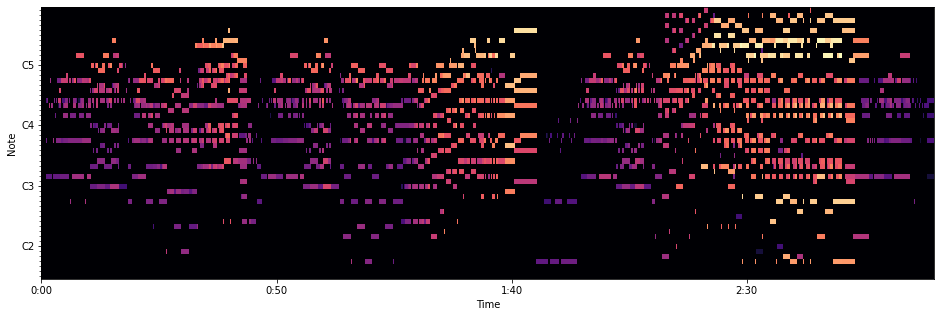

In [5]:
plt.figure(figsize=(16, 5))
handler.plot_piano_roll(0, 30, 84)

In [10]:
handler.play_audio(handler.pm[1],  60)

In [9]:
handler.print_instrument_info([0, 1, 2, 3, 4])

Total number of instruments in 0-th midi file: 1

Acoustic Grand Piano
	2655 notes
	0 pitch bends
	2551 control changes 

Total number of instruments in 1-th midi file: 1

Acoustic Grand Piano
	17872 notes
	0 pitch bends
	28489 control changes 

Total number of instruments in 2-th midi file: 1

Acoustic Grand Piano
	12936 notes
	0 pitch bends
	22402 control changes 

Total number of instruments in 3-th midi file: 1

Acoustic Grand Piano
	2968 notes
	0 pitch bends
	2347 control changes 

Total number of instruments in 4-th midi file: 1

Acoustic Grand Piano
	6528 notes
	0 pitch bends
	5616 control changes 



In [33]:
n_notes = handler.count_notes([0, 1, 2, 3, 4])
n_notes # total number of notes

42959

In [11]:
notes = handler.midi_to_notes(0, 0)
notes.head()

pitch note     start       end      step  duration
0     57   A3  1.020833  1.354167  0.000000  0.333333
1     50   D3  1.033333  2.364583  0.012500  1.331250
2     65   F4  1.041667  1.238542  0.008333  0.196875
3     69   A4  1.259375  1.332292  0.217708  0.072917
4     65   F4  1.385417  1.469792  0.126042  0.084375

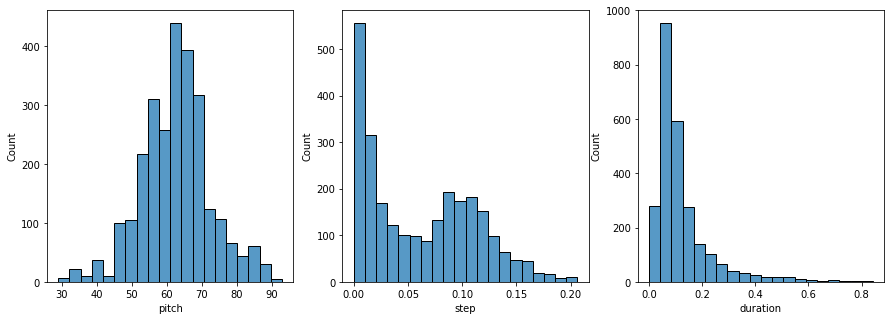

In [12]:
handler.plot_distributions(notes)

In [10]:
# create .midi file
pm = MusicHandler.notes_to_midi(notes, 'Acoustic Grand Piano')
MusicHandler.play_audio(pm, 30)

## Dataset

In [14]:
notes_list = []

for ind in trange(len(handler.pm)):
  notes_list.append(handler.midi_to_notes(ind, 0))

100%|██████████| 5/5 [00:00<00:00, 14.21it/s]


In [16]:
key_order = ['pitch', 'step', 'duration']

train_notes_list = [np.stack([notes[key] for key in key_order], axis=1) for notes in notes_list]

len(train_notes_list)

5

In [18]:
notes_ds_list = [tf.data.Dataset.from_tensor_slices(train_notes) for train_notes in train_notes_list]
len(notes_ds_list)

5

### Creating windows (each windows is an input to RNN)

In [28]:
seq_length = 32
vocab_size = 128 # number of pitches provided by pretty_midi

def create_dataset(dataset : tf.data.Dataset, seq_length=seq_length) -> tf.data.Dataset:
 
  # get sequences
  # it is dataset of datasets
  windows = dataset.window(size=seq_length + 1, shift=1, stride=1, drop_remainder=True)
  # windows.element_spec --> DatasetSpec

  # just flatten the dataset of datasets into the dataset of tensors
  flatten = lambda x: x.batch(seq_length + 1, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  # sequences.element_spec --> TensorSpec

  def split_labels(sequences):

    inputs = sequences[:-1]
    inputs /= [vocab_size, 1.0, 1.0] # 0 <= pitch <= 1

    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i, key in enumerate(key_order)}

    return inputs, labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
notes_ds = [create_dataset(notes_ds) for notes_ds in notes_ds_list]
notes_ds[0].element_spec

(TensorSpec(shape=(32, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
train_ds = notes_ds[0]

if len(notes_ds) > 1:
  for i in range(1, len(notes_ds)):
    train_ds = train_ds.concatenate(notes_ds[i])

In [34]:
batch_size = 64
buffer_size = n_notes // seq_length  # the number of items in the dataset
print(f'Total number of notes in dataset {buffer_size}')
train_ds = (train_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

Total number of notes in dataset 1342


In [35]:
train_ds.element_spec

(TensorSpec(shape=(64, 32, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Model

### Loss

In [36]:
# for step and duration we'll use mse with punishing negative outputs

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):

  mse = (y_true - y_pred) ** 2
  positive_pressure = 16 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure
}

### Building model

In [25]:
input_shape = (seq_length, 3)
learning_rate = 0.005
hidden_state_dim = 128

inputs = tf.keras.Input(input_shape)

# Add deeper LSTM layers
x = tf.keras.layers.LSTM(hidden_state_dim)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [26]:
losses = model.evaluate(train_ds, return_dict=True)
losses

426/426 [==============================] - 10s 11ms/step - loss: 5.5401 - duration_loss: 0.6563 - pitch_loss: 4.8501 - step_loss: 0.0337


{'duration_loss': 0.6563160419464111,
 'loss': 5.540118217468262,
 'pitch_loss': 4.850082874298096,
 'step_loss': 0.03371841832995415}

In [27]:
# since total loss is just a sum over all losses and the pitch loss significantly prevale others
# we should make them equal:

loss_weights = {
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
}

model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer)

In [28]:
model.evaluate(train_ds, return_dict=True)

426/426 [==============================] - 2s 4ms/step - loss: 0.9325 - duration_loss: 0.6563 - pitch_loss: 4.8501 - step_loss: 0.0337


{'duration_loss': 0.6563160419464111,
 'loss': 0.9325390458106995,
 'pitch_loss': 4.850082874298096,
 'step_loss': 0.03371841832995415}

So now they almost equally contribute in total loss

## Training

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=7, # Number of epochs with no improvement after which training will be stopped
        verbose=1,
        restore_best_weights=True),
]

In [30]:
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
426/426 [==============================] - 6s 8ms/step - loss: 0.2761 - duration_loss: 0.0508 - pitch_loss: 4.1588 - step_loss: 0.0174
Epoch 2/50
426/426 [==============================] - 3s 8ms/step - loss: 0.2601 - duration_loss: 0.0426 - pitch_loss: 4.0183 - step_loss: 0.0167
Epoch 3/50
426/426 [==============================] - 2s 5ms/step - loss: 0.2579 - duration_loss: 0.0419 - pitch_loss: 3.9853 - step_loss: 0.0167
Epoch 4/50
426/426 [==============================] - 2s 5ms/step - loss: 0.2610 - duration_loss: 0.0441 - pitch_loss: 4.0013 - step_loss: 0.0169
Epoch 5/50
426/426 [==============================] - 2s 5ms/step - loss: 0.2562 - duration_loss: 0.0408 - pitch_loss: 3.9775 - step_loss: 0.0166
Epoch 6/50
426/426 [==============================] - 2s 5ms/step - loss: 0.2545 - duration_loss: 0.0403 - pitch_loss: 3.9535 - step_loss: 0.0166
Epoch 7/50
426/426 [==============================] - 2s 5ms/step - loss: 0.2534 - duration_loss: 0.0401 - pitch_loss: 3.929

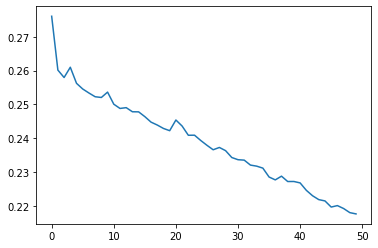

In [31]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [32]:
! du -sh training_checkpoints

49M	training_checkpoints


In [37]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [46]:
temperature = 7.0
num_predictions = 120

input_notes = (
    train_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0

for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

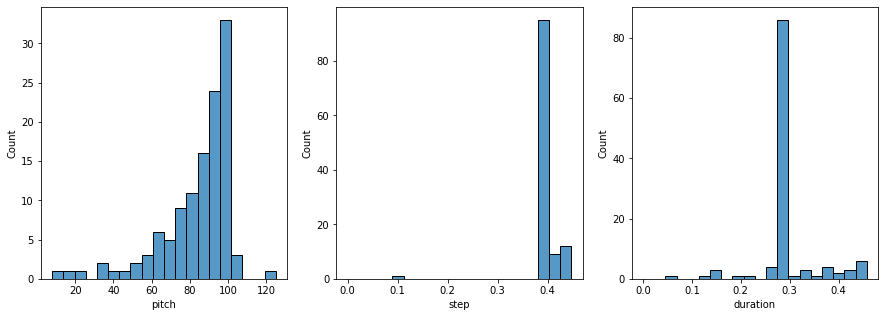

In [47]:
MusicHandler.plot_distributions(generated_notes)

In [48]:
path = '/content/data/gen1.midi'

pm_out = MusicHandler.notes_to_midi(generated_notes,
                                    instrument_name='Acoustic Grand Piano')

MusicHandler.play_audio(pm_out, 60)

In [51]:
MusicHandler.save_midi(pm_out, path)

In [52]:
inputs = tf.random.normal((64, 25, 3))

x = tf.keras.layers.LSTM(hidden_state_dim)(inputs)
x.shape

TensorShape([64, 128])